# Install and Load Libraries/Data

In [55]:
#!pip install skorch

In [56]:
import torch # type: ignore
import numpy as np  # type: ignore
import pandas as pd # type: ignore
from torch import nn # type: ignore
from skorch import NeuralNetClassifier # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [57]:
# Paths to data folders
train_csv_path = './data/merged_train.csv'
test_csv_path = './data/merged_test.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Splitting and Scaling/OneHotEncoding

In [58]:
# Separate features and target from the training data
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

# Test data (features only)
X_test = test_df.drop(columns=['id'])

In [59]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [60]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [61]:
# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale features
])

# Define preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encode
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Skorch NN

In [62]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU()):
        super().__init__()
        # Define hidden layers
        layers = []
        layer_sizes = [inp_size] + hidden_sizes + [num_classes]
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(nonlin)
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)

In [63]:
# Determine the number of input features after preprocessing
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train[:1]).shape[1]  # Use a small sample to get the shape

# Define the Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=MyModule,
    module__inp_size=num_input_features,
    module__hidden_sizes=[128, 64],
    max_epochs=20,
    lr=0.001,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.CrossEntropyLoss(),
    batch_size=256,
    iterator_train__shuffle=True,
    verbose=1,
)

# Create a Pipeline that includes preprocessing, casting to float32, and the neural network
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', to_float32),
    ('nn', net)
])

In [64]:
params = {
    'nn__lr': [0.01, 0.001],
    'nn__max_epochs': [10, 20],
    'nn__module__hidden_sizes': [[128, 64], [64, 32]],
    'nn__module__nonlin': [nn.ReLU(), nn.Tanh()],
}

In [65]:
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=10,                      # 5-fold cross-validation
    scoring='accuracy',        # Use accuracy as the scoring metric
    refit=True,                # Refit the model with the best parameters
    verbose=2,                 # Verbosity level
    n_jobs=-1                  # Utilize all available cores
)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4743       0.9385        0.1753  0.0608
      2        0.1171       0.9432        0.1427  0.0529
      3        0.0613       0.9543        0.1119  0.0648
      4        0.0436       0.9464        0.1249  0.0638
      5        0.0276       0.9543        0.1189  0.0688
      6        0.0227       0.9543        0.1303  0.0578
      7        0.0208       0.9543        0.1424  0.0559
      8        0.0219       0.9558        0.1672  0.0658
      9        0.0282       0.9558        0.1479  0.0519
     10        0.0251       0.9606        0.1507  0.0519


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'Basic_Demos-Sex',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physical-HeartRate',
                                                                          'Physical-Systolic_BP'...
                                        FunctionTransformer(func=<function <lambda> at 0x000001C9C58A6520>)),
                                       ('nn',
                                        <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MyModule'>,
  module__hidden_sizes=[128, 64],
  module__inp_size=148,
))]),
             n_jobs=-1,
             param_grid={'nn__lr': [0.01, 0.001], 'nn__max_epochs': [10, 20],
                         'nn__module__hidden_sizes': [[128, 64], [64, 32]],
                         'nn__module__nonlin': [ReLU(), Tanh()]},
             scoring='accuracy', verbose=2)

# Evaluating Skorch NN

In [66]:
# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation Accuracy: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")

# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_


Best Cross-Validation Accuracy: 0.9637
Best Parameters: {'nn__lr': 0.01, 'nn__max_epochs': 10, 'nn__module__hidden_sizes': [128, 64], 'nn__module__nonlin': Tanh()}


In [67]:
# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9646

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       563
           1       0.94      0.90      0.92       146
           2       0.90      0.93      0.92        76
           3       0.75      0.43      0.55         7

    accuracy                           0.96       792
   macro avg       0.89      0.81      0.84       792
weighted avg       0.96      0.96      0.96       792



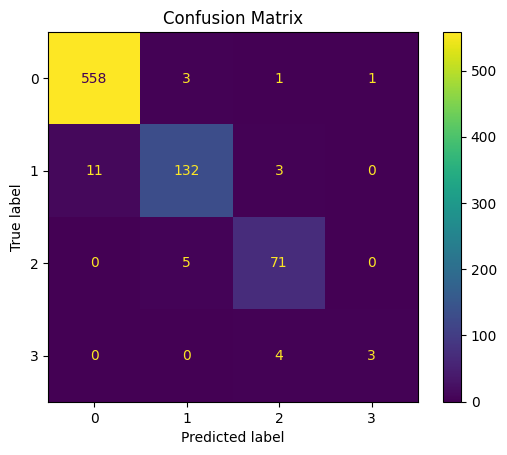

In [68]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [69]:
# Make predictions on the test set
#y_test_pred = best_pipeline.predict(X_test)

# Save the predictions to a file
#output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})
#output_df.to_csv('test_predictions.csv', index=False)